In [1]:
!pip install datashader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 54.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for datashape: filename=datashape-0.5.2-py3-none-any.whl size=59421 sha256=0d2eb960cff87a6d3da4b2afd9a83f605da833a49618e5d554f3d0dbf0b18f45
  Stored in directory: /root/.cache/pip/wheels/35/c6/63/a3c12ecc9fdea10a593271de5c56481b427ad4049b90a176e1
Successfully built datashape


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import seaborn as sns
import datashader as ds


In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
# Specify the base paths of the folders
basepath = [
    '/content/drive/My Drive/00_project/05_fly-arena/10_Locomotion/10-flies/dark/{20G06AD}{UAS-TNTE};{VT055404DBD}{+}/',
    '/content/drive/My Drive/00_project/05_fly-arena/10_Locomotion/10-flies/dark/{p65AD}{UAS-TNTE};{GAL4DBD}{+}/',
]

# Create a list to store the file names
fnames_list = []

# Iterate over the base paths
for i, dir in enumerate(basepath):
    # Find all CSV files in the directory
    fnames = sorted(glob.glob(basepath[i] + '/*el_filtered.csv', recursive=True))
    fnames_list.append(fnames)
fnames_list

[['/content/drive/My Drive/00_project/05_fly-arena/10_Locomotion/10-flies/dark/{20G06AD}{UAS-TNTE};{VT055404DBD}{+}/01_ flybowl90_{20G06AD}{UAS-TNTE};{VT055404DBD}{+}_male_10_mated_dark-2023-04-03T15_18_02DLC_dlcrnetms5_FlyBowlLocoApr5shuffle1_200000_el_filtered.csv',
  '/content/drive/My Drive/00_project/05_fly-arena/10_Locomotion/10-flies/dark/{20G06AD}{UAS-TNTE};{VT055404DBD}{+}/02_ flybowl90_{20G06AD}{UAS-TNTE};{VT055404DBD}{+}_male_10_mated_dark-2023-04-04T13_03_13DLC_dlcrnetms5_FlyBowlLocoApr5shuffle1_200000_el_filtered.csv',
  '/content/drive/My Drive/00_project/05_fly-arena/10_Locomotion/10-flies/dark/{20G06AD}{UAS-TNTE};{VT055404DBD}{+}/03_ flybowl90_{20G06AD}{UAS-TNTE};{VT055404DBD}{+}_male_10_mated_dark-2023-04-05T15_02_36DLC_dlcrnetms5_FlyBowlLocoApr5shuffle1_200000_el_filtered.csv',
  '/content/drive/My Drive/00_project/05_fly-arena/10_Locomotion/10-flies/dark/{20G06AD}{UAS-TNTE};{VT055404DBD}{+}/04_ flybowl90_{20G06AD}{UAS-TNTE};{VT055404DBD}{+}_male_10_mated_dark-2023-04

In [ ]:
def generate_egocentric_coordinates(data, frame, exp_id, group_id, arena_dia, pixel_res):
    num_flies = data.shape[0] // 4  # Number of flies

    # Reshape the data to separate head, tail, and centroid coordinates
    data_reshaped = data.reshape(num_flies, 4)

    # Multiply data_reshaped by arena_dia/pixel_res
    data_reshaped *= arena_dia / pixel_res

    hx, hy, tx, ty = data_reshaped.T

    # Compute centroid coordinates
    cx = (hx + tx) / 2.0
    cy = (hy + ty) / 2.0

    cx_affine_list = []
    cy_affine_list = []
    target_dist_list = []
    rank_list = []

    for i in range(num_flies):
        target_cx = cx[i]
        target_cy = cy[i]

        # Subtract target fly's cx and cy from all coordinates
        cx_diff = cx - target_cx
        cy_diff = cy - target_cy

        translation = [-cx_diff[i], -cy_diff[i]]
        rotation = np.arctan2(tx[i] - hx[i], -(ty[i] - hy[i]))
        cx_affine = cx_diff * np.cos(rotation) + cy_diff * np.sin(rotation)
        cy_affine = -cx_diff * np.sin(rotation) + cy_diff * np.cos(rotation)

        # Calculate the target distance
        target_dist = np.sqrt(cx_diff**2 + cy_diff**2)

        cx_affine_list.append(cx_affine)
        cy_affine_list.append(cy_affine)
        target_dist_list.append(target_dist)

        # Sort the target distances and assign ranks
        sorted_indices = np.argsort(target_dist)
        ranks = np.argsort(sorted_indices)
        rank_list.append(ranks)

    # Stack cx_affine and cy_affine for each fly
    cx_affine_stacked = np.hstack(cx_affine_list)
    cy_affine_stacked = np.hstack(cy_affine_list)
    target_dist_stacked = np.hstack(target_dist_list)
    ranks_stacked = np.hstack(rank_list)

    # Create a NumPy array with cx_affine, cy_affine, target_dist, fly_id, exp_id, group_id, and rank columns
    result_array = np.column_stack([np.repeat(group_id, cx_affine_stacked.shape[0]),
                                   np.repeat(exp_id, cx_affine_stacked.shape[0]),
                                   np.repeat(frame, cx_affine_stacked.shape[0]),
                                   np.tile(np.arange(num_flies)+1, num_flies),
                                   cx_affine_stacked,
                                   cy_affine_stacked,
                                   target_dist_stacked,ranks_stacked])


    return result_array



In [11]:
# Define the filenames for saving the DataFrames
final_df_filename = "/content/drive/My Drive/00_project/05_fly-arena/10_Locomotion/output_egocent_social/R20G06VT055404TNT_p65GAL4TNT_xy_egocent_social_20230615.pkl"

# Check if the final_df file already exists
if os.path.isfile(final_df_filename):
    # Load the final_df DataFrame from the saved file
    final_df = pd.read_pickle(final_df_filename)
    print(f"Loaded 'final_df' DataFrame from '{final_df_filename}'.")
else:

    # Create an empty list to store the results
    result_list = []

    # Iterate over the file names
    for group_id, fnames_group in enumerate(fnames_list):
        for exp_id, c in enumerate(fnames_group):
            print('File:', c)
            # Load the dataframe from a file
            df = pd.read_csv(c, header=[0, 1, 2], skiprows=[0], index_col=0)

            # Remove all columns containing "likelihood"
            df = df.loc[:, ~df.columns.get_level_values(2).str.contains('likelihood')]

            # Remove WingL and WingR at level 1 of column
            df = df.loc[:, ~df.columns.get_level_values(1).str.contains('Wing')]

            # Flatten the multi-level column index
            df.columns = df.columns.map('_'.join)
            print('df has nan values:', df.isnull().values.sum())

            # Iterate over rows
            for frame, (_, row) in enumerate(df.iterrows()):
                # Extract the data for each fly
                data = row.values

                # Generate egocentric coordinates and append to the result list
                fly_coords = generate_egocentric_coordinates(data, frame, exp_id, group_id, arena_dia=90, pixel_res=1024)

                result_list.append(fly_coords)

    # Concatenate the results into a single numpy array
    result_array = np.concatenate(result_list)

    # Convert result_array to a DataFrame
    final_df = pd.DataFrame(result_array, columns=['group_id', 'exp_id', 'frame', 'fly_id', 'cx_affine', 'cy_affine', 'nn_dist', 'rank'])

    # Convert fly_id, exp_id, group_id, and rank columns to appropriate types
    final_df['fly_id'] = final_df['fly_id'].astype(int).astype('category')
    final_df['exp_id'] = final_df['exp_id'].astype(int).astype('category')
    final_df['group_id'] = final_df['group_id'].astype(int).astype('category')
    final_df['rank'] = final_df['rank'].astype(int)

    # Save the final_df DataFrame to a file
    final_df_filename = "/content/drive/My Drive/00_project/05_fly-arena/10_Locomotion/output_egocent_social/R20G06VT055404TNT_p65GAL4TNT_xy_egocent_social_20230615.pkl"
    final_df.to_pickle(final_df_filename)
    print(f'final_df saved: {final_df_filename}')

# Print the resulting DataFrame
print(final_df.shape)
final_df.head()


File: /content/drive/My Drive/00_project/05_fly-arena/10_Locomotion/10-flies/dark/{20G06AD}{UAS-TNTE};{VT055404DBD}{+}/01_ flybowl90_{20G06AD}{UAS-TNTE};{VT055404DBD}{+}_male_10_mated_dark-2023-04-03T15_18_02DLC_dlcrnetms5_FlyBowlLocoApr5shuffle1_200000_el_filtered.csv
df has nan values: 0
File: /content/drive/My Drive/00_project/05_fly-arena/10_Locomotion/10-flies/dark/{20G06AD}{UAS-TNTE};{VT055404DBD}{+}/02_ flybowl90_{20G06AD}{UAS-TNTE};{VT055404DBD}{+}_male_10_mated_dark-2023-04-04T13_03_13DLC_dlcrnetms5_FlyBowlLocoApr5shuffle1_200000_el_filtered.csv
df has nan values: 0
File: /content/drive/My Drive/00_project/05_fly-arena/10_Locomotion/10-flies/dark/{20G06AD}{UAS-TNTE};{VT055404DBD}{+}/03_ flybowl90_{20G06AD}{UAS-TNTE};{VT055404DBD}{+}_male_10_mated_dark-2023-04-05T15_02_36DLC_dlcrnetms5_FlyBowlLocoApr5shuffle1_200000_el_filtered.csv
df has nan values: 0
File: /content/drive/My Drive/00_project/05_fly-arena/10_Locomotion/10-flies/dark/{20G06AD}{UAS-TNTE};{VT055404DBD}{+}/04_ flyb

,group_id,exp_id,frame,fly_id,cx_affine,cy_affine,nn_dist,rank
0,0,0,0.0,1,0.000000,-0.000000,0.000000,0
1,0,0,0.0,2,10.279899,-25.949070,27.911119,5
2,0,0,0.0,3,53.281238,36.378466,64.515759,9
3,0,0,0.0,4,-11.694209,6.726158,13.490579,2
4,0,0,0.0,5,51.159284,-22.303372,55.809612,8


In [72]:
cond = (final_df['rank']!=0) & (final_df['rank'] == 1)
final_df.groupby(['group_id','rank']).median()

<ipython-input-72-c96d4f935b4a>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  final_df.groupby(['group_id','rank']).median()


frame  cx_affine  cy_affine    nn_dist
group_id rank                                          
0        0     26995.0   0.000000   0.000000   0.000000
         1     26995.0  -0.546827  -0.525627  12.183283
         2     26995.0  -1.706470  -1.597139  20.369090
         3     26995.0  -1.400778  -2.991339  27.282617
         4     26995.0  -2.438690  -3.942301  33.808461
         5     26995.0  -2.936519  -5.727338  40.273283
         6     26995.0  -4.099825  -7.013825  46.349936
         7     26995.0  -5.748304  -8.287262  52.195819
         8     26995.0  -6.619868  -9.784309  58.138294
         9     26995.0  -8.106666 -12.761890  64.665137
1        0     26997.0   0.000000   0.000000   0.000000
         1     26997.0  -0.170639  -0.202308  12.231177
         2     26997.0  -1.033815  -1.896108  20.648244
         3     26997.0  -1.716811  -3.620320  28.032320
         4     26997.0  -3.174668  -5.325696  34.499694
         5     26997.0  -3.850496  -6.489295  40.624145
         6     26997.0  -5.327831  -7.950060  46.518623
         7     26997.0  -6.710974 -10.170866  52.605845
         8     26997.0  -8.839289 -12.114956  58.982739
         9     26997.0 -11.731272 -14.166076  65.475478

<Axes: xlabel='nn_dist', ylabel='Probability'>

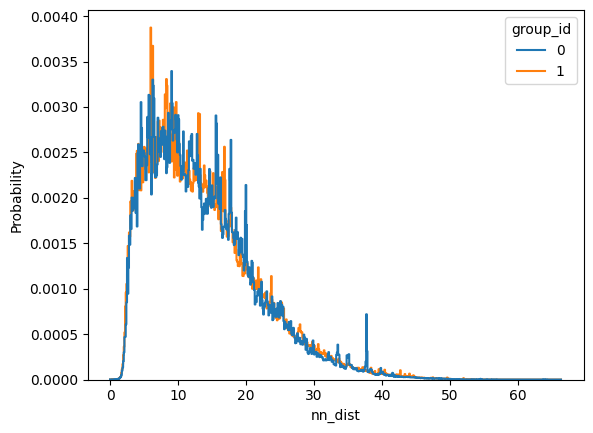

In [71]:
cond = (final_df['rank']!=0) & (final_df['rank'] == 1)
# cond = (final_df['rank']!=0) & (final_df['rank'] >= 4)
fig, ax = plt.subplots()
sns.histplot(data=final_df[cond],
             x="nn_dist", hue="group_id", stat='probability',
            #  binwidth=1,
            #  cumulative=True,
             element='step', fill=False, ax=ax)
# ax.set_xlim([0, 20])

In [ ]:
def generate_egocentric_coordinates(data, fly_id, exp_id, group_id):
    num_flies = data.shape[0] // 4  # Number of flies

    # Reshape the data to separate head, tail, and centroid coordinates
    hx = data[::4]
    hy = data[1::4]
    tx = data[2::4]
    ty = data[3::4]

    # Compute centroid coordinates
    cx = (hx + tx) / 2.0
    cy = (hy + ty) / 2.0

    cx_affine_list = []
    cy_affine_list = []

    for i in range(num_flies):
        target_cx = cx[i]
        target_cy = cy[i]

        # Subtract target fly's cx and cy from all coordinates
        cx -= target_cx
        cy -= target_cy

        translation = [-cx[i], -cy[i]]
        rotation = np.arctan2(tx[i] - hx[i], -(ty[i] - hy[i]))
        cx_affine = cx * np.cos(rotation) + cy * np.sin(rotation)
        cy_affine = -cx * np.sin(rotation) + cy * np.cos(rotation)

        cx_affine_list.append(cx_affine)
        cy_affine_list.append(cy_affine)

    # Stack cx_affine and cy_affine for each fly
    cx_affine_stacked = np.hstack(cx_affine_list)
    cy_affine_stacked = np.hstack(cy_affine_list)

    # Create a NumPy array with cx_affine, cy_affine, fly_id, exp_id, and group_id columns
    result_array = np.column_stack((cx_affine_stacked, cy_affine_stacked, np.tile(np.arange(num_flies)+1, num_flies),
                                    np.repeat(exp_id, cx_affine_stacked.shape[0]), np.repeat(group_id, cx_affine_stacked.shape[0])))

    return result_array



    #     # Scatter plot
    #     ax.scatter(cx_affine, cy_affine, label=f"Fly {i+1}", alpha=0.3)

    # ax.set_title("Distribution of Flies")
    # ax.set_xlabel("cx_affine")
    # ax.set_ylabel("cy_affine")
    # ax.legend()
    # plt.show()


# Egocentric distributions of all surrounding flies

In [ ]:
# Define the filenames for saving the DataFrames
final_df_filename = "/content/drive/My Drive/00_project/05_fly-arena/10_Locomotion/output_egocent_distributions/R20G06VT055404TNT_p65GAL4TNT_xy_egocent_surr_20230615.pkl"

# Check if the final_df file already exists
if os.path.isfile(final_df_filename):
    # Load the final_df DataFrame from the saved file
    final_df = pd.read_pickle(final_df_filename)
    print(f"Loaded 'final_df' DataFrame from '{final_df_filename}'.")

else:
    # Create an empty list to store the results
    result_list = []

    # Iterate over the file names
    for group_id, fnames_group in enumerate(fnames_list):
        for exp_id, c in enumerate(fnames_group):
            print('File:', c)
            # Load the dataframe from a file
            df = pd.read_csv(c, header=[0, 1, 2], skiprows=[0], index_col=0)

            # Remove all columns containing "likelihood"
            df = df.loc[:, ~df.columns.get_level_values(2).str.contains('likelihood')]

            # Remove WingL and WingR at level 1 of column
            df = df.loc[:, ~df.columns.get_level_values(1).str.contains('Wing')]

            # Flatten the multi-level column index
            df.columns = df.columns.map('_'.join)
            print('df has nan values:', df.isnull().values.sum())

            # Iterate over rows
            for fly_id, (_, row) in enumerate(df.iterrows()):
                # Extract the data for each fly
                data = row.values

                # Generate egocentric coordinates and append to the result list
                fly_coords = generate_egocentric_coordinates(data, fly_id, exp_id, group_id)

                result_list.append(fly_coords)

    # Concatenate the results into a single numpy array
    result_array = np.concatenate(result_list)

    # Convert result_array to a DataFrame
    final_df = pd.DataFrame(result_array, columns=['cx_affine', 'cy_affine', 'fly_id', 'exp_id', 'group_id'])

    # Convert fly_id, exp_id, and group_id columns to integer type
    final_df['fly_id'] = final_df['fly_id'].astype(int).astype('category')
    final_df['exp_id'] = final_df['exp_id'].astype(int).astype('category')
    final_df['group_id'] = final_df['group_id'].astype(int).astype('category')

    final_df.to_pickle(final_df_filename)
    print(f'final_df saved: {final_df_filename}')

# Print the resulting DataFrame
print(final_df.shape)
final_df.head()


Loaded 'final_df' DataFrame from '/content/drive/My Drive/00_project/05_fly-arena/10_Locomotion/output_egocent_distributions/R20G06VT055404TNT_p65GAL4TNT_xy_egocent_surr_20230615.pkl'.
(107986000, 5)


,cx_affine,cy_affine,fly_id,exp_id,group_id
0,0.000000,-0.000000,1.0,0.0,0.0
1,116.962408,-295.242753,2.0,0.0,0.0
2,606.222086,413.906105,3.0,0.0,0.0
3,-133.054107,76.528732,4.0,0.0,0.0
4,582.078966,-253.762808,5.0,0.0,0.0


In [ ]:
from colorcet import fire

color_key = {'0':'red', '1':'aqua'}
ds.transfer_functions.Image.border=0


cvs = ds.Canvas(plot_width=900, plot_height=900)
agg = cvs.points(final_df, 'cx_affine', 'cy_affine',
                 ds.count_cat('group_id')
                 )
img = ds.tf.shade(agg,
                  cmap=fire,
                  color_key=color_key,
                  how='eq_hist'
                #   how='log'
                  )
ds.tf.set_background(img, 'white')

KeyError: ignored

# Nearest neighbors

In [ ]:
import numpy as np
from scipy.spatial.distance import cdist

def calculate_nearest_neighbors(data, num_neighbors, random=False, fly_id=None, exp_id=None, group_id=None):
    num_flies = data.shape[0] // 4  # Number of flies

    if num_neighbors >= num_flies and not random:
        raise ValueError("The number of neighbors cannot exceed the number of flies.")

    # Reshape the data to separate head, tail, and centroid coordinates
    hx = data[::4]
    hy = data[1::4]
    tx = data[2::4]
    ty = data[3::4]

    # Compute centroid coordinates
    cx = (hx + tx) / 2.0
    cy = (hy + ty) / 2.0

    # Calculate pairwise distances between centroids
    distances = cdist(np.column_stack((cx, cy)), np.column_stack((cx, cy)))

    # Exclude self-distances
    np.fill_diagonal(distances, np.inf)

    nearest_indices = []
    for i in range(num_flies):
        if random:
            indices = np.argsort(distances[i])[1:num_neighbors+1]
        else:
            indices = np.argpartition(distances[i], num_neighbors)[:num_neighbors]
        nearest_indices.append(indices)

    nearest_indices = np.array(nearest_indices)

    nearest_distances = distances[np.arange(num_flies)[:, None], nearest_indices]

    # Calculate the mean value of nearest distances for each fly
    mean_distances = np.mean(nearest_distances, axis=1)

    # Stack mean_distances for each fly
    mean_distances_stacked = np.hstack(mean_distances)

    # Create a NumPy array with cx_affine, cy_affine, fly_id, exp_id, and group_id columns
    result_array = np.column_stack((mean_distances_stacked,
                                    np.repeat(num_neighbors, mean_distances_stacked.shape[0]),
                                    np.repeat(random, mean_distances_stacked.shape[0]),
                                    np.tile(np.arange(num_flies)+1, mean_distances_stacked.shape[0]),
                                    np.repeat(exp_id, mean_distances_stacked.shape[0]),
                                    np.repeat(group_id, mean_distances_stacked.shape[0])))
    return result_array


In [ ]:
num_neighbors = 1

# Create an empty list to store the results
result_list = []

# Iterate over the file names
for group_id, fnames_group in enumerate(fnames_list):
    for exp_id, c in enumerate(fnames_group):
        print('File:', c)
        # Load the dataframe from a file
        df = pd.read_csv(c, header=[0, 1, 2], skiprows=[0], index_col=0)

        # Remove all columns containing "likelihood"
        df = df.loc[:, ~df.columns.get_level_values(2).str.contains('likelihood')]

        # Remove WingL and WingR at level 1 of column
        df = df.loc[:, ~df.columns.get_level_values(1).str.contains('Wing')]

        # Flatten the multi-level column index
        df.columns = df.columns.map('_'.join)
        print('df has nan values:', df.isnull().values.sum())

        for r in [False, True]:
            # Iterate over rows
            for fly_id, (_, row) in enumerate(df.iterrows()):
                # Extract the data for each fly
                data = row.values

                # Generate egocentric coordinates and append to the result list
                result_array = calculate_nearest_neighbors(data, num_neighbors, random=r, fly_id=fly_id, exp_id=exp_id, group_id=group_id)

                # Generate egocentric coordinates and append to the result list
                fly_coords = generate_egocentric_coordinates(data, fly_id, exp_id, group_id)

                result_list.append(result_array)
                print(result_array)

# Concatenate the results into a single numpy array
result_array = np.concatenate(result_list)

# Convert result_array to a DataFrame
final_df = pd.DataFrame(result_array, columns=['mean_nn_dist', 'num_nn', 'random', 'fly_id', 'exp_id', 'group_id'])

# Convert fly_id, exp_id, and group_id columns to integer type
final_df['num_nn'] = final_df['num_nn'].astype('category')
final_df['random'] = final_df['random'].astype('category')
final_df['fly_id'] = final_df['fly_id'].astype('category')
final_df['exp_id'] = final_df['exp_id'].astype('category')
final_df['group_id'] = final_df['group_id'].astype('category')

base_dir = "/content/drive/My Drive/00_project/05_fly-arena/10_Locomotion/"
output_folder = "output_nearest_neighbors/"
output_filename = f"R20G06VT055404TNT_p65GAL4TNT_mean_nn_dist_20230615.pkl"
output_filepath = os.path.join(base_dir + output_folder, output_filename)
final_df.to_pickle(output_filepath)
print(f'final_df saved: {output_filepath}')

Streaming output truncated to the last 5000 lines.
[[ 76.28163032   1.           0.         442.           0.
    0.        ]
 [148.95769569   1.           0.         442.           0.
    0.        ]
 [574.45636869   1.           0.         442.           0.
    0.        ]
 [ 76.28163032   1.           0.         442.           0.
    0.        ]
 [ 96.10654171   1.           0.         442.           0.
    0.        ]
 [180.99635065   1.           0.         442.           0.
    0.        ]
 [148.95769569   1.           0.         442.           0.
    0.        ]
 [239.49807231   1.           0.         442.           0.
    0.        ]
 [206.6758404    1.           0.         442.           0.
    0.        ]
 [ 96.10654171   1.           0.         442.           0.
    0.        ]]
[[ 76.24101373   1.           0.         443.           0.
    0.        ]
 [148.93335208   1.           0.         443.           0.
    0.        ]
 [574.87106061   1.           0.         443.   

KeyboardInterrupt: ignored

In [ ]:
# Example usage
data = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])  # Example data with 1 frame and 3 flies
data = np.arange(40)
num_neighbors = 4
mean_distances = generate_egocentric_coordinates(data)
print(mean_distances)
